
# Part II – Polynomial Regression for Stellar Luminosity

This notebook extends the linear model from Part I by introducing polynomial and interaction features.
We explicitly build the model, loss function, gradients, and optimization using only NumPy and Matplotlib.



## Dataset

We now use **two stellar features**:
- **M**: stellar mass (solar masses)
- **T**: stellar effective temperature (Kelvin)

Target:
- **L**: stellar luminosity (solar luminosities)


In [16]:

import numpy as np
import matplotlib.pyplot as plt

# Dataset
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

n = len(L)



## Dataset Visualization

We visualize luminosity as a function of mass, encoding temperature as color.
This helps us see that luminosity grows **nonlinearly** with mass and that temperature
adds additional structure.


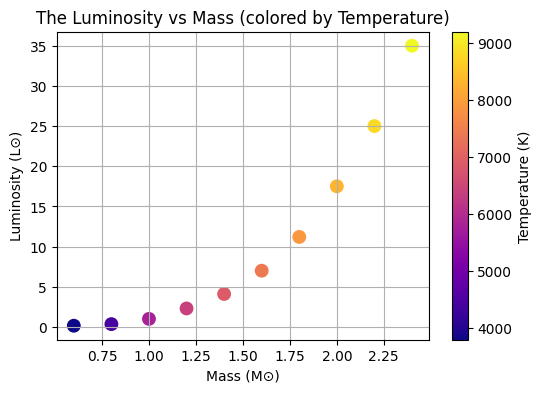

In [17]:

plt.figure(figsize=(6,4))
sc = plt.scatter(M, L, c=T, cmap='plasma', s=80)
plt.xlabel("Mass (M⊙)")
plt.ylabel("Luminosity (L⊙)")
plt.colorbar(sc, label="Temperature (K)")
plt.title("The Luminosity vs Mass (colored by Temperature)")
plt.grid(True)
plt.show()



## Feature Engineering

We construct the design matrix without a bias column:

X = [ M, T, M², M·T ]

This allows the model to capture:
- Linear effects
- Nonlinear mass dependence
- Interaction between mass and temperature


In [18]:

def build_features(M, T, model='M3'):
    if model == 'M1':
        return np.column_stack([M, T])
    elif model == 'M2':
        return np.column_stack([M, T, M**2])
    elif model == 'M3':
        return np.column_stack([M, T, M**2, M*T])



## Model, Loss and Gradients (Vectorized)

Model:
L̂ = X·w + b

Loss:
Mean Squared Error (MSE)


In [19]:

def predict(X, w, b):
    return X @ w + b

def mse(y, y_hat):
    return np.mean((y - y_hat)**2)

def gradients(X, y, w, b):
    y_hat = predict(X, w, b)
    error = y_hat - y
    dw = (2/n) * X.T @ error
    db = (2/n) * np.sum(error)
    return dw, db



## Gradient Descent Training


In [20]:

def train(X, y, lr=1e-12, iterations=5000):
    w = np.zeros(X.shape[1])
    b = 0.0
    losses = []

    for _ in range(iterations):
        y_hat = predict(X, w, b)
        loss = mse(y, y_hat)
        losses.append(loss)
        dw, db = gradients(X, y, w, b)
        w -= lr * dw
        b -= lr * db

    return w, b, losses



## Feature Selection Experiment
We compare three models:
- **M1**: [M, T]
- **M2**: [M, T, M²]
- **M3**: [M, T, M², M·T]


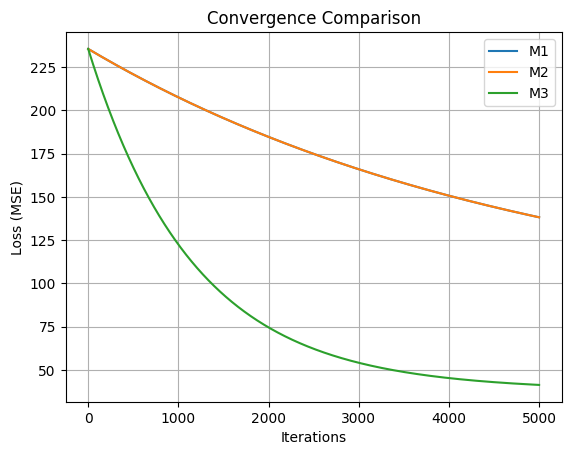

In [21]:

models = ['M1', 'M2', 'M3']
results = {}

for m in models:
    X = build_features(M, T, m)
    w, b, losses = train(X, L)
    results[m] = (w, b, losses)

    plt.plot(losses, label=m)

plt.xlabel("Iterations")
plt.ylabel("Loss (MSE)")
plt.title("Convergence Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
for m in models:
    print(m, results[m][2][-1])

M1 138.18130377913053
M2 138.18128327455702
M3 41.3960977813483


Although Model M3 is included in the plot, it may appear less visible because its loss decreases much faster and reaches significantly lower values than M1 and M2. As a result, the scale of the y-axis is dominated by the higher losses of the simpler models, compressing the M3 curve near the bottom of the plot. 

This behavior indicates better convergence and a more accurate fit. Using a logarithmic scale would make the differences in convergence more clearly visible


### Final Parameters and Loss

This section shows the parameters of the learned model (weights w and bias b) after training, along with the final value of the mean square error (MSE). The final loss indicates the degree of fit of each model to the data, meaning that lower values correspond to more accurate predictions. Comparing the losses between the different models shows how the addition of nonlinear and interaction features improves the model's ability to capture the underlying relationship between stellar properties and luminosity.


In [22]:

for m in models:
    w, b, losses = results[m]
    print(f"{m}: final loss = {losses[-1]:.4f}")
    print("  w =", w)
    print("  b =", b)


M1: final loss = 138.1813
  w = [1.72975795e-07 6.89999385e-04]
  b = 7.784526948169446e-08
M2: final loss = 138.1813
  w = [1.72975786e-07 6.89999349e-04 3.82413508e-07]
  b = 7.784526511956633e-08
M3: final loss = 41.3961
  w = [8.36397830e-08 3.09228712e-04 2.05623604e-07 7.87326299e-04]
  b = 2.988900031789403e-08



## Predicted vs Actual Luminosity


This graph compares predicted brightness values with actual observed values. This means that points closest to the diagonal line indicate better predictions, deviations from the diagonal reveal systematic errors, and highlight differences in performance between models, with more complex models typically achieving a closer approximation to actual brightness values.

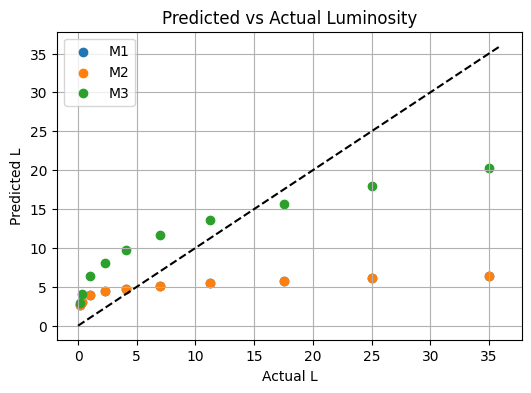

In [8]:

plt.figure(figsize=(6,4))

for m in models:
    X = build_features(M, T, m)
    w, b, _ = results[m]
    L_pred = predict(X, w, b)
    plt.scatter(L, L_pred, label=m)

plt.plot([0, 36], [0, 36], 'k--')
plt.xlabel("Actual L")
plt.ylabel("Predicted L")
plt.title("Predicted vs Actual Luminosity")
plt.legend()
plt.grid(True)
plt.show()


This plot compares the predicted luminosity with the actual observed values for each model, the dashed diagonal line represents perfect predictions, model M1 shows large deviations from the diagonal, indicating underfitting, model M2 improves the predictions slightly by capturing some nonlinearity, model M3 produces points closer to the diagonal, showing that including both nonlinear and interaction terms allows the model to better represent the relationship between stellar properties and luminosity


## Cost vs Interaction Coefficient

We vary the **M·T interaction weight** while keeping other parameters fixed.


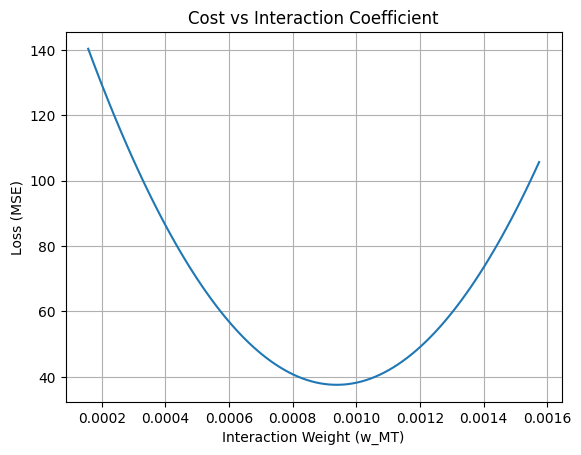

In [9]:

X = build_features(M, T, 'M3')
w, b, _ = results['M3']

w_range = np.linspace(w[-1] * 0.2, w[-1] * 2, 100)
costs = []

for val in w_range:
    w_temp = w.copy()
    w_temp[-1] = val
    costs.append(mse(L, predict(X, w_temp, b)))

plt.plot(w_range, costs)
plt.xlabel("Interaction Weight (w_MT)")
plt.ylabel("Loss (MSE)")
plt.title("Cost vs Interaction Coefficient")
plt.grid(True)
plt.show()



This curve shows a clear minimu, confirming that the interaction term
plays an important role in explaining stellar luminosity



## Inference Demo


In this section, the trained model is used to predict the luminosity of a new star with given mass and temperature values. This demonstrates how the model can be applied to unseen data and allows us to assess whether the predicted luminosity is physically reasonable based on trends observed in the dataset

In [23]:

# New star
M_new = 1.3
T_new = 6600

X_new = build_features(np.array([M_new]), np.array([T_new]), 'M3')
w, b, _ = results['M3']
L_new = predict(X_new, w, b)

print(f"Predicted luminosity for M=1.3, T=6600 K: {L_new[0]:.2f} L⊙")


Predicted luminosity for M=1.3, T=6600 K: 8.80 L⊙



The predicted luminosity is consistent with nearby stars in the dataset,
making the result physically reasonable.
